In [1]:
# !pip install nibabel
# !pip install SimpleITK
# !pip install opencv-python

### Please ensure the following structure of your folder

    .
    ├── images                                  # X-ray and ct images
    ├── snapshots                               # Model weights
    ├── custom_unet_resnet.py                   # A modified U-net model
    ├── S3_Image synthesis_GAN_advanced.ipynb   # Part 2
    ├── S3_Image synthesis_GAN_basic.ipynb      # Part 1
    └── README.md                               # Readme

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import copy

In [3]:
plt.rcParams['figure.figsize'] = (6, 6)

In [4]:
device = 'cuda'

### Part 1
## Work with CT data

In image domain the ususual data formats are: dicom, mhd, nii.

Digital Imaging and Communications in Medicine (DICOM) is the standard for the communication and management of medical imaging information and related data. DICOM is most commonly used for storing and transmitting medical images enabling the integration of medical imaging devices such as scanners, servers, workstations, printers, network hardware, and picture archiving and communication systems (PACS) from multiple manufacturers. It has been widely adopted by hospitals and is making inroads into smaller applications like dentists' and doctors' offices.

https://en.wikipedia.org/wiki/DICOM

In practice, we need an <b>image array</b> from the dicom-file and <b>some usefull tags</b>.

In [5]:
# import some useful libraries
import nibabel as nib
import SimpleITK as sitk
# more usefule libraries: nilearn, pydicom

In [6]:
ct_dicom_path = './images/ct/dicom/3000566.000000-03192/'

In [7]:
sorted(os.listdir(ct_dicom_path))[1:10]

['1-001.dcm',
 '1-002.dcm',
 '1-003.dcm',
 '1-004.dcm',
 '1-005.dcm',
 '1-006.dcm',
 '1-007.dcm',
 '1-008.dcm',
 '1-009.dcm']

In [8]:
sitk_reader = sitk.ImageSeriesReader()

dicom_names = sitk_reader.GetGDCMSeriesFileNames(ct_dicom_path)
sitk_reader.SetFileNames(dicom_names)

ct_sitk = sitk_reader.Execute()

In [9]:
ct_sitk.GetSpacing()

(0.703125, 0.703125, 2.5)

In [10]:
ct_sitk.GetOrigin()

(-166.0, -171.699997, -340.0)

In [11]:
ct_sitk.GetSize()

(512, 512, 133)

### Spacing

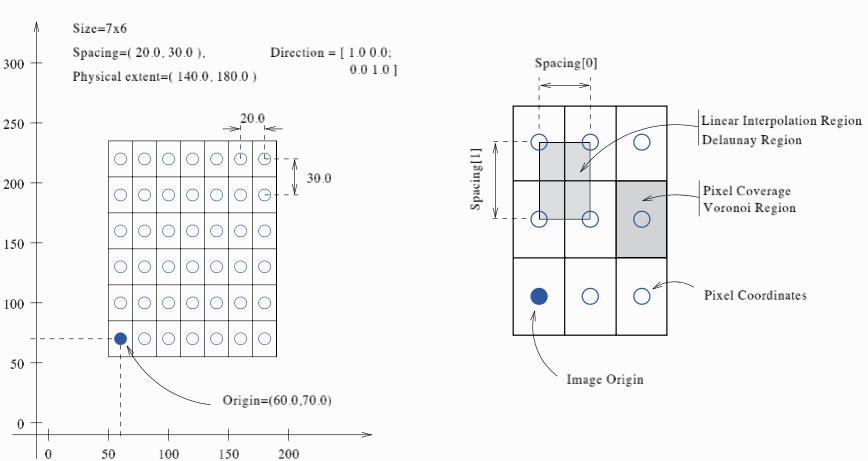

In [12]:
ct_sitk_np = sitk.GetArrayFromImage(ct_sitk)

In [13]:
ct_sitk_np.shape

(133, 512, 512)

In [14]:
print('min:', ct_sitk_np.min(), 'max:', ct_sitk_np.max(), 'mean:', ct_sitk_np.mean())

min: -2048 max: 3071 mean: -826.9439289121699


In [15]:
ct_sitk_np = np.flip(ct_sitk_np, axis=0)

### Slices

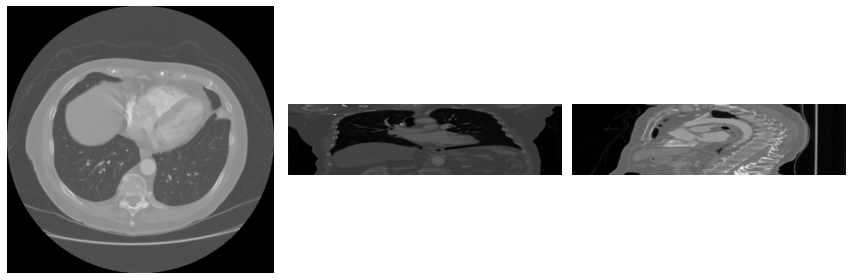

In [16]:
f = plt.figure(figsize=(12,4));
for i, tslice in enumerate([ct_sitk_np[75], ct_sitk_np[:,256], ct_sitk_np[...,256]]):
    plt.subplot(1,3,i+1)
    plt.imshow(tslice, cmap='gray');
    plt.axis('off')
plt.tight_layout();

In [17]:
ct_sitk_np[ct_sitk_np<-1024] = -1024

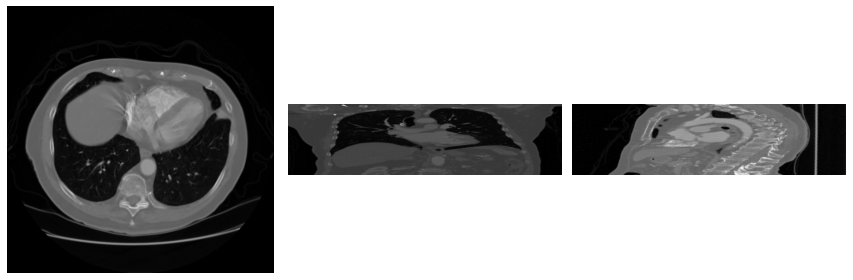

In [18]:
f = plt.figure(figsize=(12,4));
for i, tslice in enumerate([ct_sitk_np[75], ct_sitk_np[:,256], ct_sitk_np[...,256]]):
    plt.subplot(1,3,i+1)
    plt.imshow(tslice, cmap='gray');
    plt.axis('off')
plt.tight_layout();

### Projection

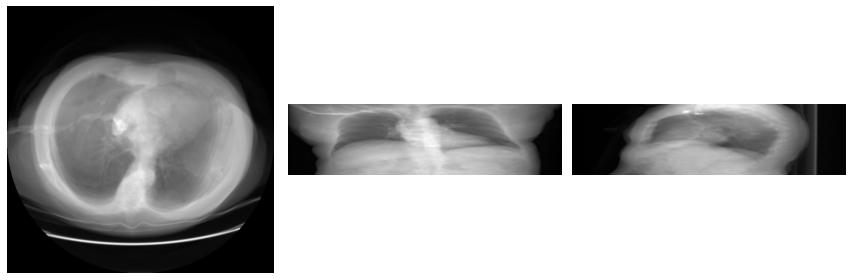

In [19]:
f = plt.figure(figsize=(12,4));
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(ct_sitk_np.mean(axis=i), cmap='gray');
    plt.axis('off')
plt.tight_layout();

### Nifty format

In [20]:
ct_nii_path = './images/ct/nii/LIDC-IDRI-0001_01-01-2000-30178_3000566.000000-03192.nii.gz'
ct_nii = nib.load(ct_nii_path)

In [21]:
ct_nii_data = ct_nii.get_fdata()
ct_nii_data.shape

(361, 361, 331)

In [22]:
ct_nii_data = np.transpose(ct_nii_data, (2,1,0))
ct_nii_data = np.flip(ct_nii_data, axis=(0,1,2))
ct_nii_data[ct_nii_data<-1024] = -1024

### Slices

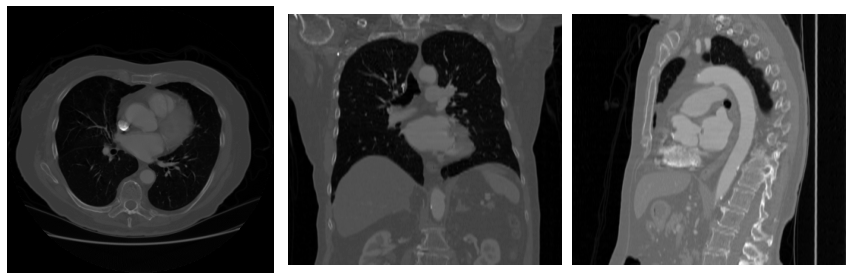

In [23]:
f = plt.figure(figsize=(12,4));
for i, tslice in enumerate([ct_nii_data[150], ct_nii_data[:,187], ct_nii_data[...,187]]):
    plt.subplot(1,3,i+1)
    plt.imshow(tslice, cmap='gray');
    plt.axis('off')
plt.tight_layout();

### Projection

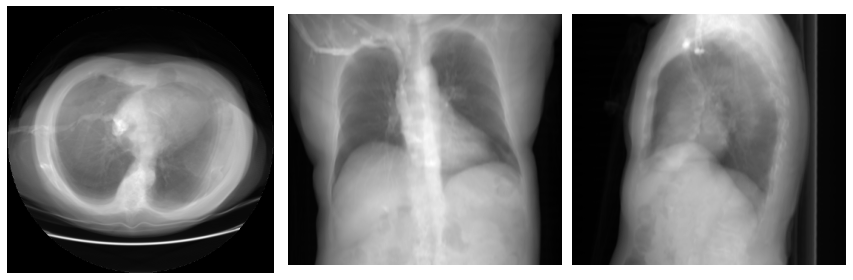

In [24]:
f = plt.figure(figsize=(12,4));
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(ct_nii_data.mean(axis=i), cmap='gray');
    plt.axis('off')
plt.tight_layout();

### Hounsfield scale

is a quantitative scale for describing radiodensity. It is frequently used in CT scans, where its value is also termed CT number.

https://en.wikipedia.org/wiki/Hounsfield_scale


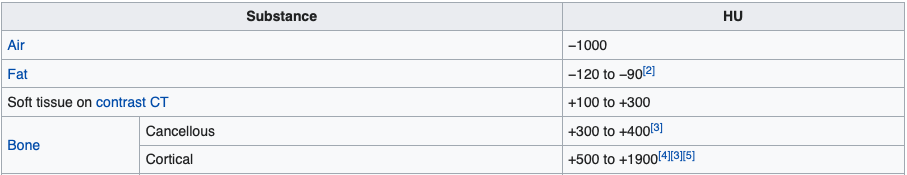

In [25]:
# let's make bones more visible
bone_min = 300
bone_max = 1900
ct_nii_data[(ct_nii_data > bone_min)&(ct_nii_data < bone_max)] *= 3

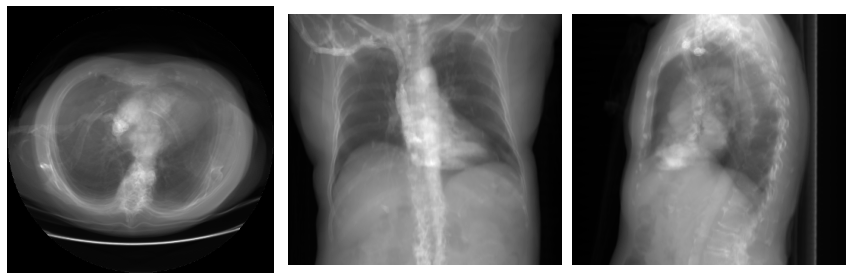

In [26]:
f = plt.figure(figsize=(12,4));
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(ct_nii_data.mean(axis=i), cmap='gray');
    plt.axis('off')
plt.tight_layout();

## Generate tube-shaped objects on Chest X-ray
### Part 2

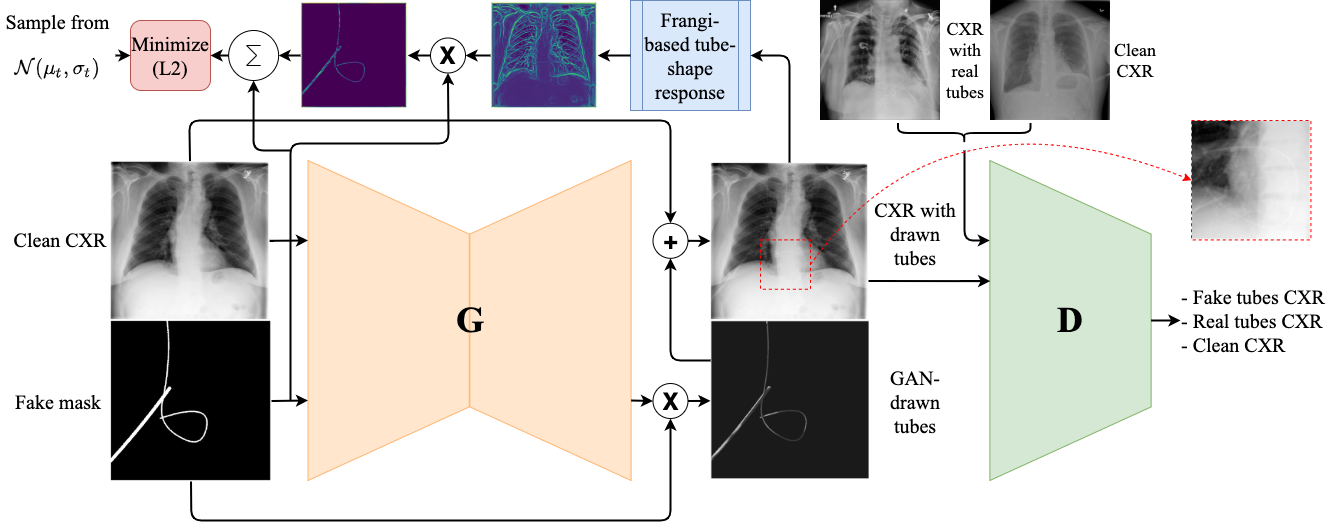

In this notebook we will infer a pre-trained $G$-model.

In [27]:
from custom_unet_resnet import get_custom_unet_resnet

In [28]:
# model params
g_weights_path = './snapshots/unet2tubes/custom_unet_cxrNtubes.pth'
c_unet_params = {
    'bias': True,
    'blocks_in_layer': 2,
    'decoder_kernels': [2, 3],
    'downsample_type': 'conv',
    'expand_rate': 2,
    'final_activation': 'linear',
    'in_channels': 2,
    'kernel_sizes': [3]*8,
    'mode': 'reg',
    'normalization': 'instance',
    'out_channels': 1,
    'start_features_num': 16
}
# data params
imgs_path = './images/cxr_clear/'
masks_path = './images/masks/'
target_shape = (512,512)

In [29]:
# define and load some weights
unet_G = get_custom_unet_resnet(**c_unet_params)
unet_G.to(device);
unet_G.load_state_dict(torch.load(g_weights_path, map_location=device))
unet_G.eval();

In [30]:
#img_id = np.random.choice(os.listdir(imgs_path))
img_id = '00000334_003.png'
img = cv2.imread(os.path.join(imgs_path, img_id), 0)
mask = cv2.imread(os.path.join(masks_path, img_id), 0)

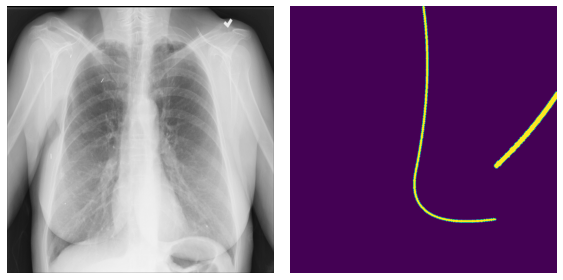

In [31]:
f = plt.figure(figsize=(8,4));
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask);
plt.axis('off')
plt.tight_layout();

In [32]:
# process data
img = cv2.resize(img, target_shape, interpolation=cv2.INTER_CUBIC).astype(np.float32)
mask = cv2.resize(mask, target_shape, interpolation=cv2.INTER_NEAREST).astype(np.float32)

img = (img / 127.5) - 1
mask[mask > 0] = 1

gen_input = np.stack((img, mask), axis=0)
gen_input = torch.from_numpy(gen_input).unsqueeze(0).to(device)
print('input shape:', gen_input.size())

input shape: torch.Size([1, 2, 512, 512])


In [33]:
with torch.no_grad():
    pred = unet_G(gen_input)
painted_tubes = torch.tanh(pred[0,0]).cpu().numpy()

In [34]:
img_tubes = copy.deepcopy(img)
img_tubes[mask==1] += painted_tubes[mask==1]

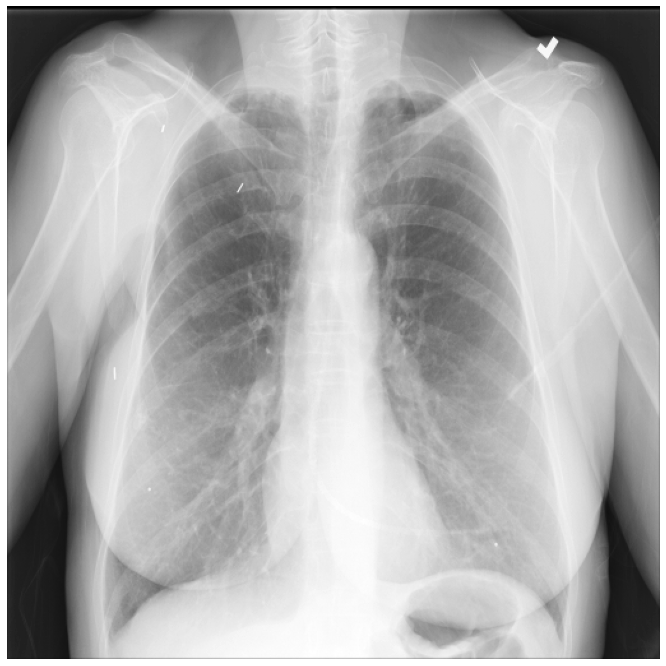

In [35]:
f = plt.figure(figsize=(12,12));
img_tubes = np.clip(img_tubes, -1, 1)
plt.imshow(img_tubes, cmap='gray')
plt.axis('off');